In [16]:
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from scipy.stats import gaussian_kde as GKDE

from scipy.stats import multivariate_normal
from scipy.stats import norm

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import random

import matplotlib.patches as patches

import src.weightedEDFs as wEDFs
import src.distributionsDCI as distDCI
import src.utils as utils

import seaborn as sns
import matplotlib as mpl

In [2]:
plot_directory = './plots'

if not os.path.exists(plot_directory):
    os.makedirs(plot_directory)

mpl.rcParams['lines.linewidth'] = 4
plt.rc('font', size=14)
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=16)
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['figure.figsize'] = (5.5, 4)
mpl.rcParams['lines.linewidth'] = 2.5

CB_color_cycle = ('#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00')
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=CB_color_cycle) 
plt.rcParams['image.cmap'] = 'viridis'

In [3]:
import torch, time
from mpl_toolkits import mplot3d

In [48]:
random.seed(37)
np.random.seed(27)

In [49]:
# Redefine the parameters of the model
D_in, D_out = 100, 3
H1, H2, H3, H4, H5 = 80, 60, 40, 20, 10

model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H1),
    torch.nn.ReLU(),
    torch.nn.Linear(H1, H2),
    torch.nn.ReLU(),
    torch.nn.Linear(H2, H3),
    torch.nn.ReLU(),
    torch.nn.Linear(H3, H4),
    torch.nn.ReLU(),
    torch.nn.Linear(H4, H5),
    torch.nn.ReLU(),
    torch.nn.Linear(H5, D_out),
)

# Read in the previously trained model
model.load_state_dict(torch.load('./data/trained_model.pt'))

<All keys matched successfully>

In [50]:
n_init_samples = 10000
init_samples = np.random.multivariate_normal(np.zeros(100), np.identity(100), n_init_samples)
init_samples = torch.from_numpy(init_samples).float()

pred_samples_full = model(init_samples)
pred_samples_full = pred_samples_full.detach().numpy()

init_samples = init_samples.detach().numpy()

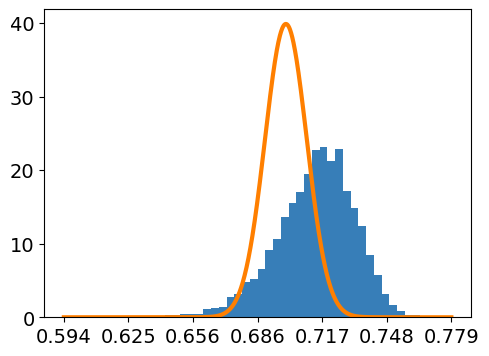

In [51]:
plt.hist(pred_samples_full[:,0], bins=50, density=True);
xx = np.linspace(np.min(pred_samples_full[:,0]), np.max(pred_samples_full[:,0]), 1000)
plt.plot(xx, norm(0.7,0.01).pdf(xx), linewidth=3);
plt.xticks(ticks=np.linspace(np.min(xx), np.max(xx), 7),
           labels=["{:.3f}".format(x) for x in np.linspace(np.min(xx), np.max(xx), 7)],
           fontsize=14)
plt.yticks(fontsize=14);

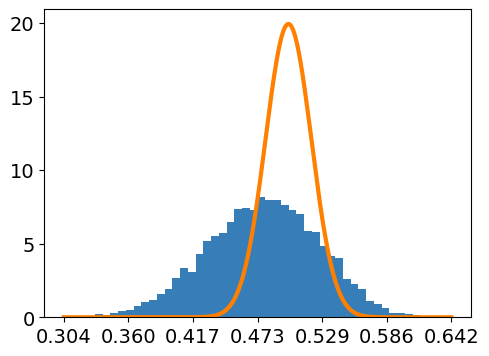

In [52]:
plt.hist(pred_samples_full[:,2], bins=50, density=True);
xx = np.linspace(np.min(pred_samples_full[:,2]), np.max(pred_samples_full[:,2]), 1000)
plt.plot(xx, norm(0.5, 0.02).pdf(xx), linewidth=3);
plt.xticks(ticks=np.linspace(np.min(xx), np.max(xx), 7),
           labels=["{:.3f}".format(x) for x in np.linspace(np.min(xx), np.max(xx), 7)],
           fontsize=14)
plt.yticks(fontsize=14);

In [53]:
n_obs_samples = 5000

obs_samples = np.zeros((n_obs_samples, 2))
obs_samples[:,0] = np.random.normal(0.7, 0.01, (n_obs_samples,))
obs_samples[:,1] = np.random.normal(0.5, 0.02, (n_obs_samples,))

In [54]:
pred_samples = pred_samples_full[:,[0,2]]

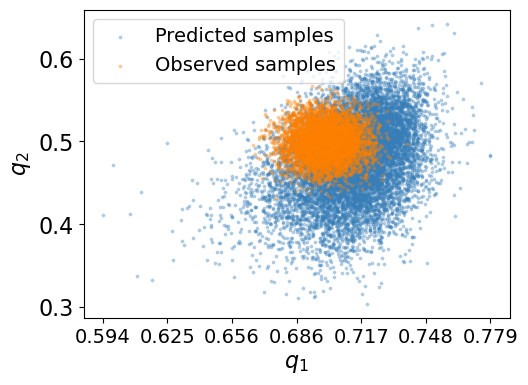

In [55]:
plt.scatter(pred_samples[:,0], pred_samples[:,1], alpha=0.3, label='Predicted samples', color='#377eb8', s=3)
plt.scatter(obs_samples[:,0], obs_samples[:,1], alpha=0.3, label='Observed samples', color='#ff7f00', s=3)
plt.xticks(ticks=np.linspace(np.min(pred_samples[:,0]), np.max(pred_samples[:,0]), 7),
           labels=["{:.3f}".format(x) for x in np.linspace(np.min(pred_samples[:,0]), np.max(pred_samples[:,0]), 7)],
           fontsize=14);
plt.xlabel(r'$q_1$', fontsize=16)
plt.ylabel(r'$q_2$', fontsize=16)
plt.legend(fontsize=14)
plt.yticks(fontsize=16);
plt.savefig(f'{plot_directory}/ml_D_samples.png', bbox_inches='tight')

In [56]:
pred_KDE = GKDE(pred_samples.T)
obs_KDE = GKDE(obs_samples.T)
r = obs_KDE(pred_samples.T) / pred_KDE(pred_samples.T)
rn_w = r / n_init_samples
PF_update_KDE = GKDE(pred_samples.T, weights=rn_w)

print(np.mean(r))

0.9957089555346192


In [57]:
n_clusters = 600
w, labels, centers, w_cluster = binning.computePartitionedWeights_kMeans_IID(init_samples,
                                                                             pred_samples,
                                                                             sample_set_2=obs_samples,
                                                                             n_clusters=n_clusters)

/var/folders/0h/yvwpnbtd37l25kkvtssf6gtc0000gn/T/ipykernel_22251/3863331764.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(["{:.5f}".format(x) for x in np.linspace(np.min(w), np.max(w), 9)],


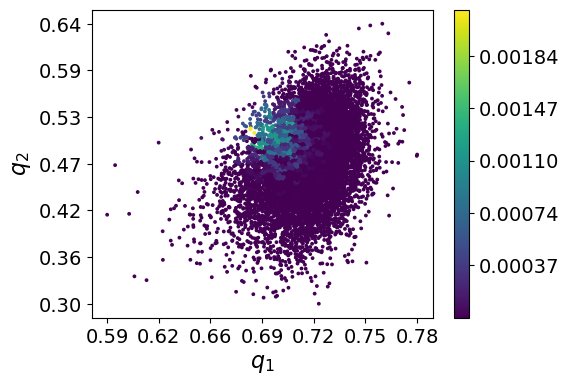

In [58]:
plt.scatter(pred_samples[:,0], pred_samples[:,1], cmap='viridis', c=w, s=3)
plt.xlabel(r'$q_1$', fontsize=16)
plt.ylabel(r'$q_2$', fontsize=16)
plt.xticks(fontsize=14,
           ticks=np.linspace(np.min(pred_samples[:,0]), np.max(pred_samples[:,0]), 7),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(pred_samples[:,0]), np.max(pred_samples[:,0]), 7)])
plt.yticks(fontsize=14,
           ticks=np.linspace(np.min(pred_samples[:,1]), np.max(pred_samples[:,1]), 7),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(pred_samples[:,1]), np.max(pred_samples[:,1]), 7)])

cbar = plt.colorbar();
cbar.ax.set_yticklabels(["{:.5f}".format(x) for x in np.linspace(np.min(w), np.max(w), 9)],
                        fontsize=14);
plt.savefig(f'{plot_directory}/ml_kmeans_2d.png', bbox_inches='tight')

/var/folders/0h/yvwpnbtd37l25kkvtssf6gtc0000gn/T/ipykernel_22251/3387873264.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(["{:.5f}".format(x) for x in np.linspace(np.min(rn_w), np.max(rn_w), 9)],


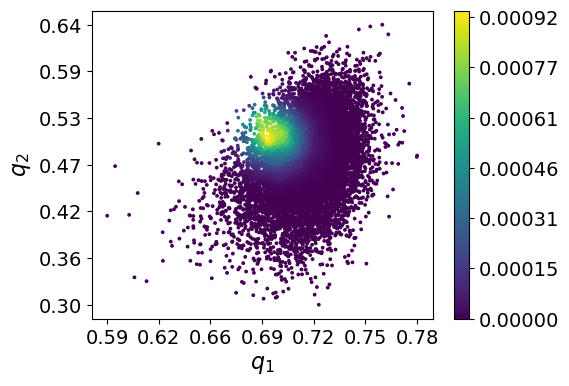

In [59]:
plt.scatter(pred_samples[:,0], pred_samples[:,1], cmap='viridis', c=rn_w, s=3)
plt.xlabel(r'$q_1$', fontsize=16)
plt.ylabel(r'$q_2$', fontsize=16)
plt.xticks(fontsize=14,
           ticks=np.linspace(np.min(pred_samples[:,0]), np.max(pred_samples[:,0]), 7),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(pred_samples[:,0]), np.max(pred_samples[:,0]), 7)])
plt.yticks(fontsize=14,
           ticks=np.linspace(np.min(pred_samples[:,1]), np.max(pred_samples[:,1]), 7),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(pred_samples[:,1]), np.max(pred_samples[:,1]), 7)])

cbar = plt.colorbar();
cbar.ax.set_yticklabels(["{:.5f}".format(x) for x in np.linspace(np.min(rn_w), np.max(rn_w), 9)],
                        fontsize=14);
plt.savefig(f'{plot_directory}/ml_rn_2d.png', bbox_inches='tight')

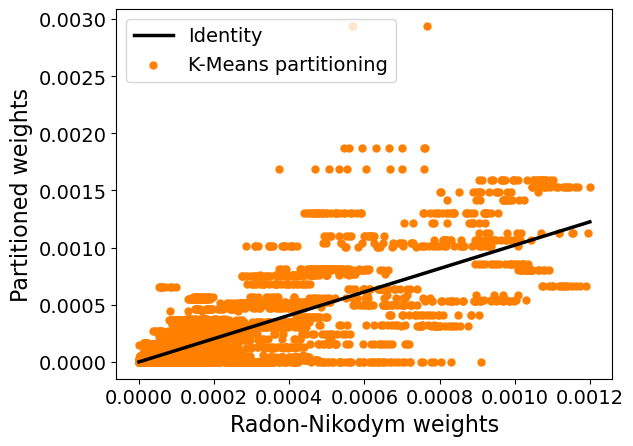

In [60]:
plt.figure(figsize=(6.4,4.8))
plt.plot(np.linspace(0, np.max(rn_w), 1000),
         np.linspace(0, np.max(rn_w), 1000), color='k', label='Identity')

plt.xlabel('Radon-Nikodym weights', fontsize=16)
plt.ylabel('Partitioned weights', fontsize=16)
plt.scatter(rn_w, w, label='K-Means partitioning', color='#ff7f00')
plt.xticks(fontsize=14,
           ticks=np.linspace(np.min(rn_w), np.max(rn_w), 7),
           labels=["{:.4f}".format(x) for x in np.linspace(np.min(w), np.max(rn_w), 7)])
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.savefig(f'{plot_directory}/ml_kmeans_2d_comp.png', bbox_inches='tight')

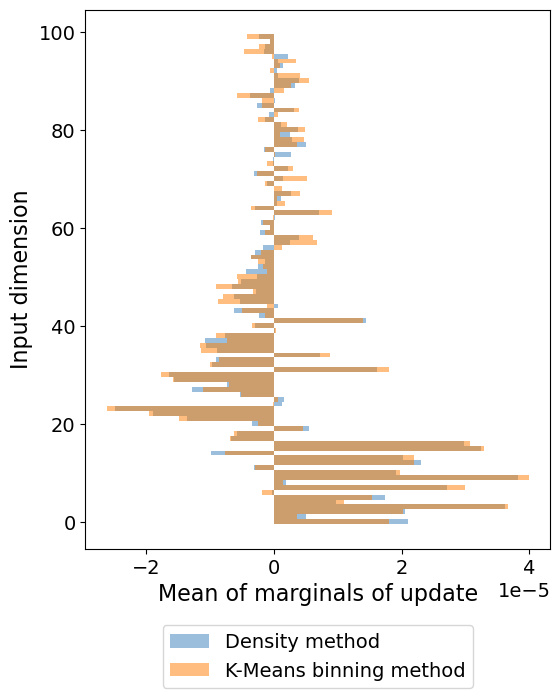

In [61]:
means_rn = np.mean((init_samples.T * rn_w).T, axis=0)
means_opt = np.mean((init_samples.T * w).T, axis=0)

plt.figure(figsize=(6,7))
plt.barh(range(100), means_rn, alpha=0.5, height=1, label='Density method')
plt.barh(range(100), means_opt, alpha=0.5, height=1, label='K-Means binning method')
plt.xlabel('Mean of marginals of update', fontsize=16)
plt.ylabel('Input dimension', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14, loc='center', bbox_to_anchor=(0.5, -0.2))
plt.savefig(f'{plot_directory}/ml_kl_kmeans_2d.png', bbox_inches='tight')

In [62]:
n_bins = [32, 30]
w, labels, centers, w_cluster = distDCI.computePartitionedWeights_regulargrid_IID(init_samples,
                                                                                  pred_samples,
                                                                                  sample_set_2=obs_samples,
                                                                                  n_bins=n_bins,
                                                                                  remove_empty_bins=True)

/var/folders/0h/yvwpnbtd37l25kkvtssf6gtc0000gn/T/ipykernel_22251/4033776764.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(["{:.5f}".format(x) for x in np.linspace(np.min(w), np.max(w), 9)],


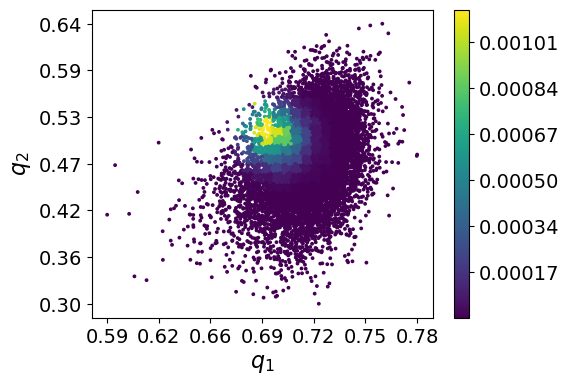

In [63]:
plt.scatter(pred_samples[:,0], pred_samples[:,1], cmap='viridis', c=w, s=3)
plt.xlabel(r'$q_1$', fontsize=16)
plt.ylabel(r'$q_2$', fontsize=16)
plt.xticks(fontsize=14,
           ticks=np.linspace(np.min(pred_samples[:,0]), np.max(pred_samples[:,0]), 7),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(pred_samples[:,0]), np.max(pred_samples[:,0]), 7)])
plt.yticks(fontsize=14,
           ticks=np.linspace(np.min(pred_samples[:,1]), np.max(pred_samples[:,1]), 7),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(pred_samples[:,1]), np.max(pred_samples[:,1]), 7)])

cbar = plt.colorbar();
cbar.ax.set_yticklabels(["{:.5f}".format(x) for x in np.linspace(np.min(w), np.max(w), 9)],
                        fontsize=14);
plt.savefig(f'{plot_directory}/ml_rgrid_2d.png', bbox_inches='tight')

/var/folders/0h/yvwpnbtd37l25kkvtssf6gtc0000gn/T/ipykernel_22251/4229524026.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(["{:.5f}".format(x) for x in np.linspace(np.min(rn_w), np.max(rn_w), 9)],


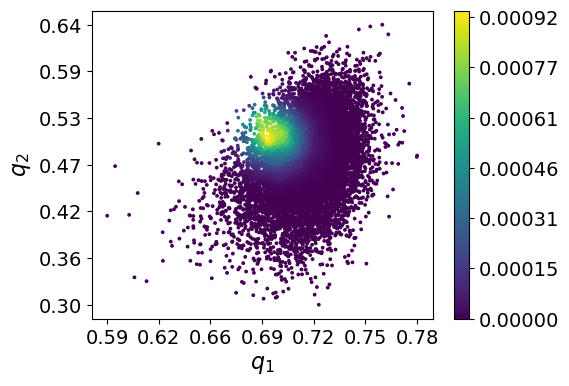

In [64]:
plt.scatter(pred_samples[:,0], pred_samples[:,1], cmap='viridis', c=rn_w, s=3)
plt.xlabel(r'$q_1$', fontsize=16)
plt.ylabel(r'$q_2$', fontsize=16)
plt.xticks(fontsize=14,
           ticks=np.linspace(np.min(pred_samples[:,0]), np.max(pred_samples[:,0]), 7),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(pred_samples[:,0]), np.max(pred_samples[:,0]), 7)])
plt.yticks(fontsize=14,
           ticks=np.linspace(np.min(pred_samples[:,1]), np.max(pred_samples[:,1]), 7),
           labels=["{:.2f}".format(x) for x in np.linspace(np.min(pred_samples[:,1]), np.max(pred_samples[:,1]), 7)])

cbar = plt.colorbar();
cbar.ax.set_yticklabels(["{:.5f}".format(x) for x in np.linspace(np.min(rn_w), np.max(rn_w), 9)],
                        fontsize=14);

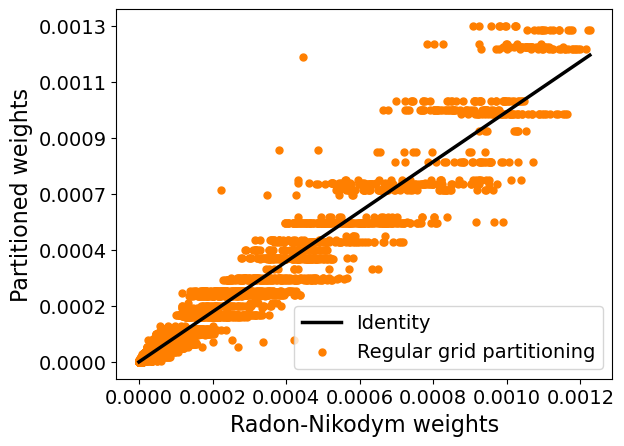

In [65]:
plt.figure(figsize=(6.4,4.8))
plt.plot(np.linspace(0, np.max(rn_w), 1000),
         np.linspace(0, np.max(rn_w), 1000), color='k', label='Identity')

plt.xlabel('Radon-Nikodym weights', fontsize=16)
plt.ylabel('Partitioned weights', fontsize=16)
plt.scatter(rn_w, w, label='Regular grid partitioning', color='#ff7f00')
plt.yticks(fontsize=14,
           ticks=np.linspace(np.min(w), np.max(w), 7),
           labels=["{:.4f}".format(x) for x in np.linspace(np.min(w), np.max(w), 7)])
plt.legend(fontsize=14)
plt.savefig(f'{plot_directory}/ml_rgrid_2d_comp.png', bbox_inches='tight')

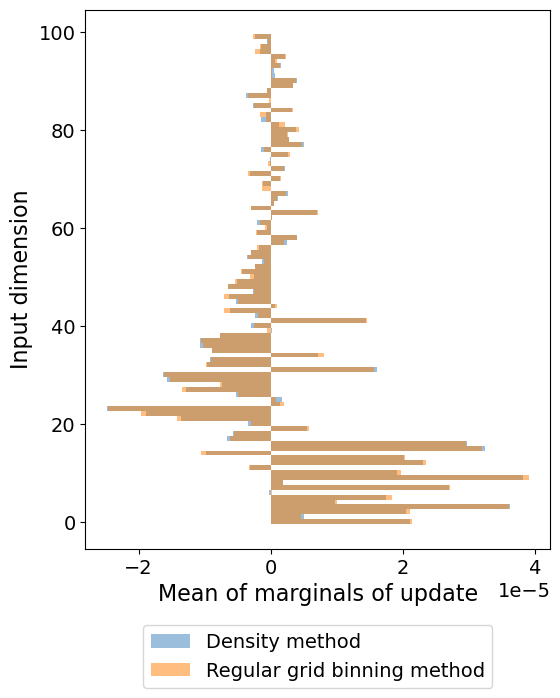

In [66]:
means_rn = np.mean((init_samples.T * rn_w).T, axis=0)
means_opt = np.mean((init_samples.T * w).T, axis=0)

plt.figure(figsize=(6,7))
plt.barh(range(100), means_rn, alpha=0.5, height=1, label='Density method')
plt.barh(range(100), means_opt, alpha=0.5, height=1, label='Regular grid binning method')
plt.xlabel('Mean of marginals of update', fontsize=16)
plt.ylabel('Input dimension', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14, loc='center', bbox_to_anchor=(0.5, -0.2))
plt.savefig(f'{plot_directory}/ml_kl_rgrid_2d.png', bbox_inches='tight')

## 1d version to match 2018 paper

In [67]:
pred_samples_1d = pred_samples[:,:1]
obs_samples_1d = obs_samples[:,:1]

In [68]:
pred_KDE_1d = GKDE(pred_samples_1d.T)
obs_KDE_1d = GKDE(obs_samples_1d.T)
r_1d = obs_KDE_1d(pred_samples_1d.T) / pred_KDE_1d(pred_samples_1d.T)
rn_w_1d = r_1d / n_init_samples
PF_update_KDE_1d = GKDE(pred_samples_1d.T, weights=rn_w_1d)

print(np.mean(r_1d))

0.9977299878736682


In [69]:
n_clusters = 40
w_1d, labels, centers, w_cluster = distDCI.computePartitionedWeights_kMeans_IID(init_samples,
                                                                             pred_samples_1d,
                                                                             sample_set_2=obs_samples_1d,
                                                                             n_clusters=n_clusters)

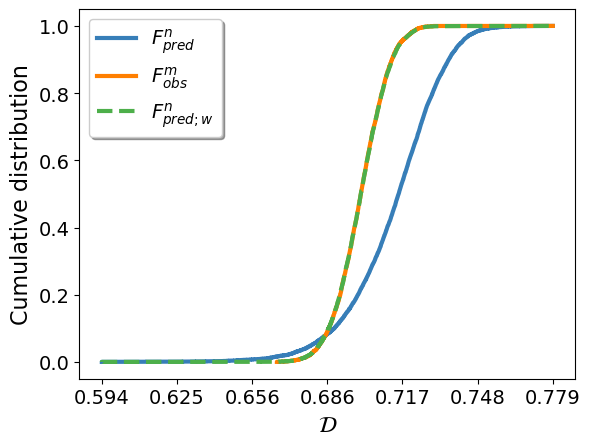

In [70]:
plt.figure(figsize=(6.4,4.8))

isort = np.argsort(pred_samples_1d[:,0])
isort_obs = np.argsort(obs_samples_1d[:,0])

plt.step(pred_samples_1d[isort], np.cumsum([1/n_init_samples]*n_init_samples),
         label=r'$F^n_{pred}$', c='#377eb8', linewidth=3)
plt.step(np.append(obs_samples_1d[isort_obs], [np.max(pred_samples_1d)]),
         np.append(np.cumsum([1/n_obs_samples]*n_obs_samples), [1]),
         label=r'$F^m_{obs}$', c='#ff7f00', linewidth=3)
plt.step(pred_samples_1d[isort], np.cumsum(w_1d[isort]),
         label=r'$F^n_{pred;w}$', c='#4daf4a', ls='dashed', linewidth=3)
plt.xticks(ticks=np.linspace(np.min(pred_samples[:,0]), np.max(pred_samples[:,0]), 7),
           labels=["{:.3f}".format(x) for x in np.linspace(np.min(pred_samples[:,0]), np.max(pred_samples[:,0]), 7)],
           fontsize=14);
plt.yticks(fontsize=14);

plt.xlabel(r'$\mathcal{D}$', fontsize=16)
plt.ylabel('Cumulative distribution', fontsize=16)
plt.legend(fontsize=14, loc='upper left', shadow=True)
plt.savefig(f'{plot_directory}/ml_kl_res_1d.png', bbox_inches='tight')

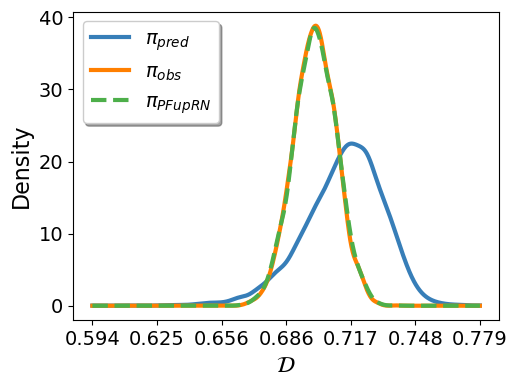

In [71]:
xx = np.linspace(np.min(pred_samples_1d), np.max(pred_samples_1d), 1000)
plt.plot(xx, pred_KDE_1d(xx), label=r'$\pi_{pred}$', linewidth=3)
plt.plot(xx, obs_KDE_1d(xx), label=r'$\pi_{obs}$', linewidth=3)
plt.plot(xx, PF_update_KDE_1d(xx), label=r'$\pi_{PFupRN}$', linewidth=3, ls='--')
plt.legend(fontsize=14)
plt.xticks(ticks=np.linspace(np.min(pred_samples[:,0]), np.max(pred_samples[:,0]), 7),
           labels=["{:.3f}".format(x) for x in np.linspace(np.min(pred_samples[:,0]), np.max(pred_samples[:,0]), 7)],
           fontsize=14);
plt.yticks(fontsize=14);

plt.xlabel(r'$\mathcal{D}$', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.legend(fontsize=14, loc='upper left', shadow=True)
plt.savefig(f'{plot_directory}/ml_kl_res_dens_1d.png', bbox_inches='tight')

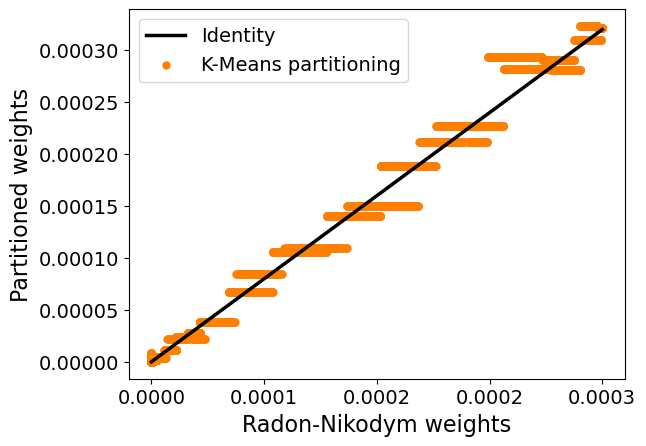

In [72]:
plt.figure(figsize=(6.4,4.8))
plt.plot(np.linspace(0, np.max(rn_w_1d), 1000),
         np.linspace(0, np.max(rn_w_1d), 1000), color='k', label='Identity')

plt.xlabel('Radon-Nikodym weights', fontsize=16)
plt.ylabel('Partitioned weights', fontsize=16)
plt.scatter(rn_w_1d, w_1d, label='K-Means partitioning', color='#ff7f00')
plt.xticks(fontsize=14,
           ticks=np.linspace(np.min(rn_w_1d), np.max(rn_w_1d), 5),
           labels=["{:.4f}".format(x) for x in np.linspace(np.min(rn_w_1d), np.max(rn_w_1d), 5)])
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.savefig(f'{plot_directory}/ml_kmeans_comp_1d.png', bbox_inches='tight')

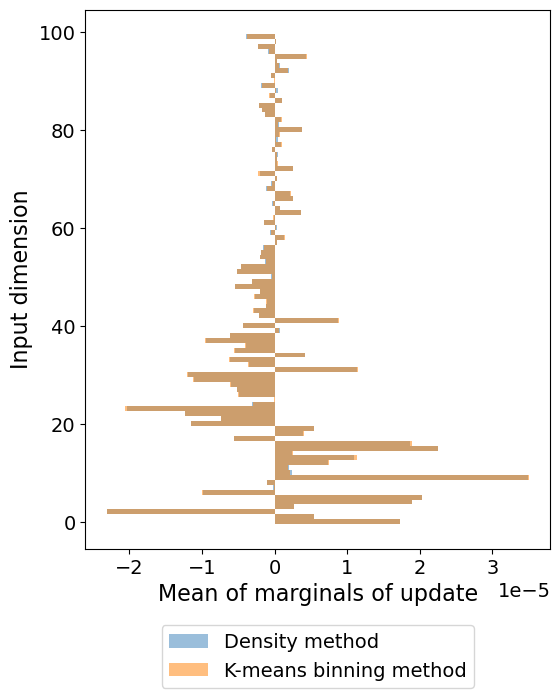

In [73]:
means_rn = np.mean((init_samples.T * rn_w_1d).T, axis=0)
means_opt = np.mean((init_samples.T * w_1d).T, axis=0)

plt.figure(figsize=(6,7))
plt.barh(range(100), means_rn, alpha=0.5, height=1, label='Density method')
plt.barh(range(100), means_opt, alpha=0.5, height=1, label='K-means binning method')
plt.legend()

plt.xlabel('Mean of marginals of update', fontsize=16)
plt.ylabel('Input dimension', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14, loc='center', bbox_to_anchor=(0.5, -0.2))
plt.savefig(f'{plot_directory}/ml_kl_kmeans_1d.png', bbox_inches='tight')

In [74]:
n_bins = 40
w_1d, labels, centers, w_cluster = distDCI.computePartitionedWeights_regulargrid_IID(init_samples,
                                                                             pred_samples_1d,
                                                                             sample_set_2=obs_samples_1d,
                                                                             n_bins=n_bins)
print(len(centers))

40


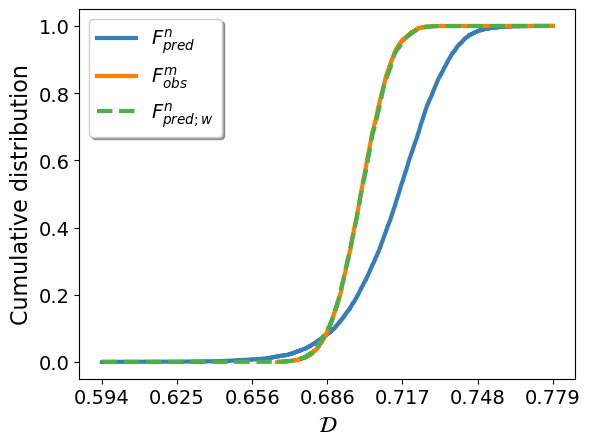

In [75]:
plt.figure(figsize=(6.4,4.8))

isort = np.argsort(pred_samples_1d[:,0])
isort_obs = np.argsort(obs_samples_1d[:,0])

plt.step(pred_samples_1d[isort], np.cumsum([1/n_init_samples]*n_init_samples),
         label=r'$F^n_{pred}$', c='#377eb8', linewidth=3)
plt.step(np.append(obs_samples_1d[isort_obs], [np.max(pred_samples_1d)]),
         np.append(np.cumsum([1/n_obs_samples]*n_obs_samples), [1]),
         label=r'$F^m_{obs}$', c='#ff7f00', linewidth=3)
plt.step(pred_samples_1d[isort], np.cumsum(w_1d[isort]),
         label=r'$F^n_{pred;w}$', c='#4daf4a', ls='dashed', linewidth=3)

plt.xticks(ticks=np.linspace(np.min(pred_samples[:,0]), np.max(pred_samples[:,0]), 7),
           labels=["{:.3f}".format(x) for x in np.linspace(np.min(pred_samples[:,0]), np.max(pred_samples[:,0]), 7)],
           fontsize=14);
plt.yticks(fontsize=14);

plt.xlabel(r'$\mathcal{D}$', fontsize=16)
plt.ylabel('Cumulative distribution', fontsize=16)
plt.legend(fontsize=14, loc='upper left', shadow=True)
plt.savefig(f'{plot_directory}/ml_kl_res_rgrid_1d.png', bbox_inches='tight')

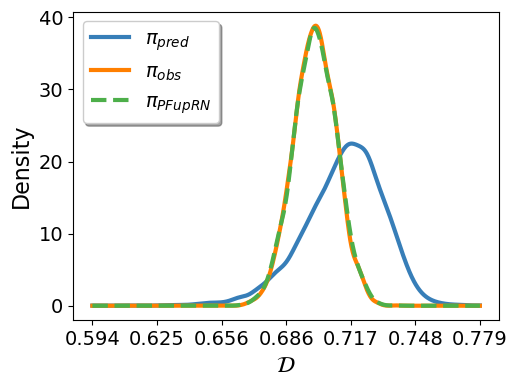

In [76]:
xx = np.linspace(np.min(pred_samples_1d), np.max(pred_samples_1d), 1000)
plt.plot(xx, pred_KDE_1d(xx), label=r'$\pi_{pred}$', linewidth=3)
plt.plot(xx, obs_KDE_1d(xx), label=r'$\pi_{obs}$', linewidth=3)
plt.plot(xx, PF_update_KDE_1d(xx), label=r'$\pi_{PFupRN}$', linewidth=3, ls='--')
plt.legend(fontsize=14)
plt.xticks(ticks=np.linspace(np.min(pred_samples[:,0]), np.max(pred_samples[:,0]), 7),
           labels=["{:.3f}".format(x) for x in np.linspace(np.min(pred_samples[:,0]), np.max(pred_samples[:,0]), 7)],
           fontsize=14);
plt.yticks(fontsize=14);

plt.xlabel(r'$\mathcal{D}$', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.legend(fontsize=14, loc='upper left', shadow=True)
plt.savefig(f'{plot_directory}/ml_kl_res_rgrid_dens_1d.png', bbox_inches='tight')

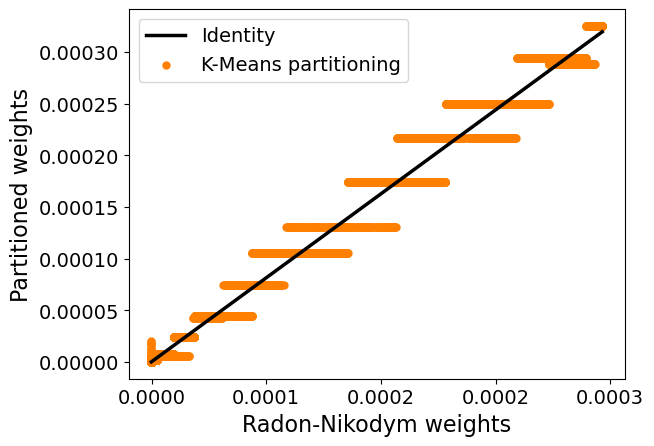

In [77]:
plt.figure(figsize=(6.4,4.8))
plt.plot(np.linspace(0, np.max(rn_w_1d), 1000),
         np.linspace(0, np.max(rn_w_1d), 1000), color='k', label='Identity')

plt.xlabel('Radon-Nikodym weights', fontsize=16)
plt.ylabel('Partitioned weights', fontsize=16)
plt.scatter(rn_w_1d, w_1d, label='K-Means partitioning', color='#ff7f00')
plt.xticks(fontsize=14,
           ticks=np.linspace(np.min(w_1d), np.max(w_1d), 5),
           labels=["{:.4f}".format(x) for x in np.linspace(np.min(w_1d), np.max(w_1d), 5)])
plt.yticks(fontsize=14)
plt.legend(fontsize=14)

plt.savefig(f'{plot_directory}/ml_rgrid_comp_1d.png', bbox_inches='tight')

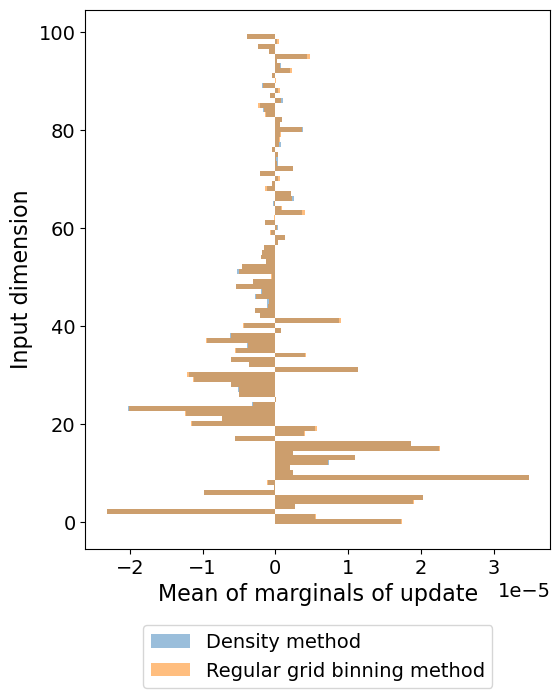

In [78]:
means_rn = np.mean((init_samples.T * rn_w_1d).T, axis=0)
means_opt = np.mean((init_samples.T * w_1d).T, axis=0)

plt.figure(figsize=(6,7))
plt.barh(range(100), means_rn, alpha=0.5, height=1, label='Density method')
plt.barh(range(100), means_opt, alpha=0.5, height=1, label='Regular grid binning method')
plt.legend()

plt.xlabel('Mean of marginals of update', fontsize=16)
plt.ylabel('Input dimension', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14, loc='center', bbox_to_anchor=(0.5, -0.2))
plt.savefig(f'{plot_directory}/ml_km_rgrid_1d.png', bbox_inches='tight')